<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [3]:
import os
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn import metrics

from sklearn import model_selection

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [4]:
rooth_path = '../rawdata/proc_data/'
df_train_gearbox = pd.read_csv(rooth_path + 'df_train_gearbox.csv')
df_train_gen = pd.read_csv(rooth_path + 'df_train_gen.csv')
df_train_gen_bear = pd.read_csv(rooth_path + 'df_train_gen_bear.csv')
df_train_hyd = pd.read_csv(rooth_path + 'df_train_hyd.csv')
df_train_transf = pd.read_csv(rooth_path + 'df_train_transf.csv')

In [5]:
df_test_gen = pd.read_csv(rooth_path + 'df_test_gen.csv')
df_test_gearbox = pd.read_csv(rooth_path + 'df_test_gearbox.csv')
df_test_gen_bear = pd.read_csv(rooth_path + 'df_test_gen_bear.csv')
df_test_hyd = pd.read_csv(rooth_path + 'df_test_hyd.csv')
df_test_transf = pd.read_csv(rooth_path + 'df_test_transf.csv')

FileNotFoundError: [Errno 2] File b'../rawdata/proc_data/df_test_gen.csv' does not exist: b'../rawdata/proc_data/df_test_gen.csv'

In [ ]:
df_train_gearbox['Timestamp'] = pd.to_datetime(df_train_gearbox['Timestamp'])
df_train_gen['Timestamp'] = pd.to_datetime(df_train_gen['Timestamp'])
df_train_gen_bear['Timestamp'] = pd.to_datetime(df_train_gen_bear['Timestamp'])
df_train_hyd['Timestamp'] = pd.to_datetime(df_train_hyd['Timestamp'])
df_train_transf['Timestamp'] = pd.to_datetime(df_train_transf['Timestamp'])
df_test_gearbox['Timestamp'] = pd.to_datetime(df_test_gearbox['Timestamp'])
df_test_gen['Timestamp'] = pd.to_datetime(df_test_gen['Timestamp'])
df_test_gen_bear['Timestamp'] = pd.to_datetime(df_test_gen_bear['Timestamp'])
df_test_hyd['Timestamp'] = pd.to_datetime(df_test_hyd['Timestamp'])
df_test_transf['Timestamp'] = pd.to_datetime(df_test_transf['Timestamp'])

In [ ]:
#Group by day per turbine
def group_per_frequency(df, strategy='mean'):
    df['Date'] = df['Timestamp'].dt.date
    if strategy == 'max':
        df = df.groupby(by=['Turbine_ID','Date']).max().reset_index().drop(columns='Timestamp')
    else:
        df = df.groupby(by=['Turbine_ID','Date']).mean().reset_index()
        
    return df

In [ ]:
df_train_gearbox_day = group_per_frequency(df_train_gearbox)
df_train_gen_day = group_per_frequency(df_train_gen)
df_train_gen_bear_day = group_per_frequency(df_train_gen_bear)
df_train_hyd_day = group_per_frequency(df_train_hyd)
df_train_transf_day = group_per_frequency(df_train_transf)
df_test_gearbox_day = group_per_frequency(df_test_gearbox)
df_test_gen_day = group_per_frequency(df_test_gen)
df_test_gen_bear_day = group_per_frequency(df_test_gen_bear)
df_test_hyd_day = group_per_frequency(df_test_hyd)
df_test_transf_day = group_per_frequency(df_test_transf)

In [ ]:
df_train_gen_day['60_days'] = df_train_gen_day['60_days'].round(decimals=0)
df_test_gen_day['60_days'] = df_test_gen_day['60_days'].round(decimals=0)

In [ ]:
def add_features(df_in, rolling_win_size):
    """Add rolling average and rolling standard deviation for sensors readings using fixed rolling window size.
    Args:
            df_in (dataframe)     : The input dataframe to be proccessed (training or test)
            rolling_win_size (int): The window size, number of cycles for applying the rolling function
    Returns:
            dataframe: contains the input dataframe with additional rolling mean and std for each sensor
    """
    
    sensor_cols = []
    for i in df_in.keys()[2:-5]:
        sensor_cols.append(i)
    sensor_av_cols = [nm+'_av' for nm in sensor_cols]
    sensor_sd_cols = [nm+'_sd' for nm in sensor_cols]
    df_out = pd.DataFrame()
    ws = rolling_win_size
    #calculate rolling stats for each engine id
    for m_id in pd.unique(df_in.Turbine_ID):
        # get a subset for each engine sensors
        df_engine = df_in[df_in['Turbine_ID'] == m_id]
        df_sub = df_engine[sensor_cols]
        # get rolling mean for the subset
        av = df_sub.rolling(ws, min_periods=1).mean()
        av.columns = sensor_av_cols
        # get the rolling standard deviation for the subset
        sd = df_sub.rolling(ws, min_periods=1).std().fillna(0)
        sd.columns = sensor_sd_cols
        # combine the two new subset dataframes columns to the engine subset
        new_ftrs = pd.concat([df_engine,av,sd], axis=1)
        # add the new features rows to the output dataframe
        df_out = pd.concat([df_out,new_ftrs])
    return df_out

In [ ]:
df_train_gearbox_extra = add_features(df_train_gearbox_day, 25)
df_train_gen_extra = add_features(df_train_gen_day, 25)
df_train_gen_bear_extra = add_features(df_train_gen_bear_day, 25)
df_train_hyd_extra = add_features(df_train_hyd_day, 25)
df_train_transf_extra = add_features(df_train_transf_day, 25)
df_test_gearbox_extra = add_features(df_test_gearbox_day, 25)
df_test_gen_extra = add_features(df_test_gen_day, 25)
df_test_gen_bear_extra = add_features(df_test_gen_bear_day, 25)
df_test_hyd_extra = add_features(df_test_hyd_day, 25)
df_test_transf_extra = add_features(df_test_transf_day, 25)

In [ ]:
df_train_gearbox_extra_feat = ['Turbine_ID', 'Gear_Oil_Temp_Avg_av', 'Gear_Bear_Temp_Avg_av', 'Rtr_RPM_Avg_av',
                               'Grd_RtrInvPhase2_Temp_Avg_av', 'Rtr_RPM_Std_av',
                               'Amb_WindSpeed_Max_av', 'Amb_WindSpeed_Min_av', 'Amb_WindSpeed_Avg_av',
                               'Amb_WindSpeed_Std_av', 'Amb_WindDir_Relative_Avg_av',
                               'Amb_WindDir_Abs_Avg_av', 'Amb_Temp_Avg_av', 'Blds_PitchAngle_Avg_av',
                               'Blds_PitchAngle_Std_av', 'Cont_Top_Temp_Avg_av',
                               'Cont_Hub_Temp_Avg_av', 'Cont_VCP_ChokcoilTemp_Avg_av',
                               'Cont_VCP_WtrTemp_Avg_av', 'Nac_Temp_Avg_av', 'Nac_Direction_Avg_av',
                               'Hyd_Oil_Temp_Avg_av', 'Gear_Oil_Temp_Avg_sd', 'Gear_Bear_Temp_Avg_sd',
                               'Rtr_RPM_Avg_sd', 'Grd_RtrInvPhase2_Temp_Avg_sd', 'Rtr_RPM_Std_sd',
                               'Amb_WindSpeed_Max_sd', 'Amb_WindSpeed_Min_sd', 'Amb_WindSpeed_Avg_sd',
                               'Amb_WindSpeed_Std_sd', 'Amb_WindDir_Relative_Avg_sd',
                               'Amb_WindDir_Abs_Avg_sd', 'Amb_Temp_Avg_sd', 'Blds_PitchAngle_Avg_sd',
                               'Blds_PitchAngle_Std_sd', 'Cont_Top_Temp_Avg_sd',
                               'Cont_Hub_Temp_Avg_sd', 'Cont_VCP_ChokcoilTemp_Avg_sd',
                               'Cont_VCP_WtrTemp_Avg_sd', 'Nac_Temp_Avg_sd', 'Nac_Direction_Avg_sd',
                               'Hyd_Oil_Temp_Avg_sd','Component','Date', 'TTF', '60_days', '30_days', '10_days']
df_gen_bear_extra_feat = ['Turbine_ID','Gen_RPM_Avg_av', 'Gen_RPM_Std_av',
                           'Gen_Bear_Temp_Avg_av', 'Gen_Phase2_Temp_Avg_av',
                           'Prod_LatestAvg_ActPwrGen0_av', 'Prod_LatestAvg_ActPwrGen1_av',
                           'Prod_LatestAvg_ReactPwrGen0_av', 'Gen_SlipRing_Temp_Avg_av',
                           'Gen_Bear2_Temp_Avg_av', 'Grd_RtrInvPhase2_Temp_Avg_av',
                           'Amb_WindSpeed_Max_av', 'Amb_WindSpeed_Min_av', 'Amb_WindSpeed_Avg_av',
                           'Amb_WindSpeed_Std_av', 'Amb_WindDir_Relative_Avg_av',
                           'Amb_WindDir_Abs_Avg_av', 'Amb_Temp_Avg_av', 'Blds_PitchAngle_Avg_av',
                           'Blds_PitchAngle_Std_av', 'Cont_Top_Temp_Avg_av',
                           'Cont_VCP_ChokcoilTemp_Avg_av', 'Cont_VCP_WtrTemp_Avg_av',
                           'Nac_Temp_Avg_av', 'Nac_Direction_Avg_av', 'Grd_Busbar_Temp_Avg_av',
                           'Hyd_Oil_Temp_Avg_av', 'Gen_RPM_Avg_sd', 'Gen_RPM_Std_sd',
                           'Gen_Bear_Temp_Avg_sd', 'Gen_Phase2_Temp_Avg_sd',
                           'Prod_LatestAvg_ActPwrGen0_sd', 'Prod_LatestAvg_ActPwrGen1_sd',
                           'Prod_LatestAvg_ReactPwrGen0_sd', 'Gen_SlipRing_Temp_Avg_sd',
                           'Gen_Bear2_Temp_Avg_sd', 'Grd_RtrInvPhase2_Temp_Avg_sd',
                           'Amb_WindSpeed_Max_sd', 'Amb_WindSpeed_Min_sd', 'Amb_WindSpeed_Avg_sd',
                           'Amb_WindSpeed_Std_sd', 'Amb_WindDir_Relative_Avg_sd',
                           'Amb_WindDir_Abs_Avg_sd', 'Amb_Temp_Avg_sd', 'Blds_PitchAngle_Avg_sd',
                           'Blds_PitchAngle_Std_sd', 'Cont_Top_Temp_Avg_sd',
                           'Cont_VCP_ChokcoilTemp_Avg_sd', 'Cont_VCP_WtrTemp_Avg_sd',
                           'Nac_Temp_Avg_sd', 'Nac_Direction_Avg_sd', 'Grd_Busbar_Temp_Avg_sd',
                           'Hyd_Oil_Temp_Avg_sd', 'Component', 'Date', 'TTF', '60_days', '30_days', '10_days']
df_gen_extra_feat = ['Turbine_ID','Gen_RPM_Avg_av', 'Gen_RPM_Std_av',
                       'Gen_Bear_Temp_Avg_av', 'Gen_Phase2_Temp_Avg_av',
                       'Prod_LatestAvg_ActPwrGen0_av', 'Prod_LatestAvg_ActPwrGen1_av',
                       'Prod_LatestAvg_ReactPwrGen0_av', 'Gen_SlipRing_Temp_Avg_av',
                       'Gen_Bear2_Temp_Avg_av', 'Grd_RtrInvPhase2_Temp_Avg_av',
                       'Amb_WindSpeed_Max_av', 'Amb_WindSpeed_Min_av', 'Amb_WindSpeed_Avg_av',
                       'Amb_WindSpeed_Std_av', 'Amb_WindDir_Relative_Avg_av',
                       'Amb_WindDir_Abs_Avg_av', 'Amb_Temp_Avg_av', 'Blds_PitchAngle_Avg_av',
                       'Blds_PitchAngle_Std_av', 'Cont_Top_Temp_Avg_av',
                       'Cont_VCP_ChokcoilTemp_Avg_av', 'Cont_VCP_WtrTemp_Avg_av',
                       'Nac_Temp_Avg_av', 'Nac_Direction_Avg_av', 'Grd_Busbar_Temp_Avg_av',
                       'Hyd_Oil_Temp_Avg_av', 'Gen_RPM_Avg_sd', 'Gen_RPM_Std_sd',
                       'Gen_Bear_Temp_Avg_sd', 'Gen_Phase2_Temp_Avg_sd',
                       'Prod_LatestAvg_ActPwrGen0_sd', 'Prod_LatestAvg_ActPwrGen1_sd',
                       'Prod_LatestAvg_ReactPwrGen0_sd', 'Gen_SlipRing_Temp_Avg_sd',
                       'Gen_Bear2_Temp_Avg_sd', 'Grd_RtrInvPhase2_Temp_Avg_sd',
                       'Amb_WindSpeed_Max_sd', 'Amb_WindSpeed_Min_sd', 'Amb_WindSpeed_Avg_sd',
                       'Amb_WindSpeed_Std_sd', 'Amb_WindDir_Relative_Avg_sd',
                       'Amb_WindDir_Abs_Avg_sd', 'Amb_Temp_Avg_sd', 'Blds_PitchAngle_Avg_sd',
                       'Blds_PitchAngle_Std_sd', 'Cont_Top_Temp_Avg_sd',
                       'Cont_VCP_ChokcoilTemp_Avg_sd', 'Cont_VCP_WtrTemp_Avg_sd',
                       'Nac_Temp_Avg_sd', 'Nac_Direction_Avg_sd', 'Grd_Busbar_Temp_Avg_sd',
                       'Hyd_Oil_Temp_Avg_sd', 'Component', 'Date', 'TTF', '60_days', '30_days', '10_days']
df_hyd_extra_feat = ['Turbine_ID','Hyd_Oil_Temp_Avg_av', 'Rtr_RPM_Avg_av',
                       'Grd_RtrInvPhase2_Temp_Avg_av', 'Rtr_RPM_Std_av',
                       'Amb_WindSpeed_Max_av', 'Amb_WindSpeed_Min_av', 'Amb_WindSpeed_Avg_av',
                       'Amb_WindSpeed_Std_av', 'Amb_WindDir_Relative_Avg_av',
                       'Amb_WindDir_Abs_Avg_av', 'Amb_Temp_Avg_av', 'Blds_PitchAngle_Avg_av',
                       'Blds_PitchAngle_Std_av', 'Cont_Top_Temp_Avg_av',
                       'Cont_VCP_ChokcoilTemp_Avg_av', 'Cont_VCP_WtrTemp_Avg_av',
                       'Nac_Temp_Avg_av', 'Nac_Direction_Avg_av', 'Hyd_Oil_Temp_Avg_sd',
                       'Rtr_RPM_Avg_sd', 'Grd_RtrInvPhase2_Temp_Avg_sd', 'Rtr_RPM_Std_sd',
                       'Amb_WindSpeed_Max_sd', 'Amb_WindSpeed_Min_sd', 'Amb_WindSpeed_Avg_sd',
                       'Amb_WindSpeed_Std_sd', 'Amb_WindDir_Relative_Avg_sd',
                       'Amb_WindDir_Abs_Avg_sd', 'Amb_Temp_Avg_sd', 'Blds_PitchAngle_Avg_sd',
                       'Blds_PitchAngle_Std_sd', 'Cont_Top_Temp_Avg_sd',
                       'Cont_VCP_ChokcoilTemp_Avg_sd', 'Cont_VCP_WtrTemp_Avg_sd',
                       'Nac_Temp_Avg_sd', 'Nac_Direction_Avg_sd','Date', 'Component', 'TTF', '60_days', '30_days', '10_days']
df_transf_extra_feat = ['Turbine_ID','HVTrafo_Phase2_Temp_Avg_av',
                       'Rtr_RPM_Avg_av', 'Grd_RtrInvPhase2_Temp_Avg_av', 'Rtr_RPM_Std_av',
                       'Amb_WindSpeed_Max_av', 'Amb_WindSpeed_Min_av', 'Amb_WindSpeed_Avg_av',
                       'Amb_WindSpeed_Std_av', 'Amb_WindDir_Relative_Avg_av',
                       'Amb_WindDir_Abs_Avg_av', 'Amb_Temp_Avg_av', 'Blds_PitchAngle_Avg_av',
                       'Blds_PitchAngle_Std_av', 'Cont_Top_Temp_Avg_av',
                       'Cont_Hub_Temp_Avg_av', 'Cont_VCP_ChokcoilTemp_Avg_av',
                       'Cont_VCP_WtrTemp_Avg_av', 'Nac_Temp_Avg_av', 'Nac_Direction_Avg_av',
                       'Grd_Busbar_Temp_Avg_av', 'Grd_Prod_VoltPhse1_Avg_av',
                       'Grd_Prod_VoltPhse2_Avg_av', 'Grd_Prod_VoltPhse3_Avg_av',
                       'HVTrafo_Phase2_Temp_Avg_sd', 'Rtr_RPM_Avg_sd',
                       'Grd_RtrInvPhase2_Temp_Avg_sd', 'Rtr_RPM_Std_sd',
                       'Amb_WindSpeed_Max_sd', 'Amb_WindSpeed_Min_sd', 'Amb_WindSpeed_Avg_sd',
                       'Amb_WindSpeed_Std_sd', 'Amb_WindDir_Relative_Avg_sd',
                       'Amb_WindDir_Abs_Avg_sd', 'Amb_Temp_Avg_sd', 'Blds_PitchAngle_Avg_sd',
                       'Blds_PitchAngle_Std_sd', 'Cont_Top_Temp_Avg_sd',
                       'Cont_Hub_Temp_Avg_sd', 'Cont_VCP_ChokcoilTemp_Avg_sd',
                       'Cont_VCP_WtrTemp_Avg_sd', 'Nac_Temp_Avg_sd', 'Nac_Direction_Avg_sd',
                       'Grd_Busbar_Temp_Avg_sd', 'Grd_Prod_VoltPhse1_Avg_sd',
                       'Grd_Prod_VoltPhse2_Avg_sd', 'Grd_Prod_VoltPhse3_Avg_sd','Date', 'Component', 'TTF', '60_days', '30_days', '10_days']

In [ ]:
df_gen_train_feat_ext = df_train_gen_extra[df_gen_extra_feat]
df_gen_test_feat_ext = df_test_gen_extra[df_gen_extra_feat]

In [ ]:
#Standard scaler per Turbine
def scale(df_train, df_test, scaler='StandardScaler'):
    
    X_train = df_train.drop(columns=['Date', 'TTF', '60_days', '30_days', '10_days', 'Component'])
    X_test = df_test.drop(columns=['Date', 'TTF', '60_days', '30_days', '10_days', 'Component'])
    
    X_train1 = X_train.loc[X_train['Turbine_ID']=='T01']
    X_test1 = X_test.loc[X_test['Turbine_ID']=='T01']
    
    X_train1 = X_train1.drop(columns='Turbine_ID')
    X_test1 = X_test1.drop(columns='Turbine_ID')
    
    if scaler == 'MinMaxScaler':
        sc = MinMaxScaler()
        X_train1 = sc.fit_transform(X_train1)
        X_test1 = sc.transform(X_test1)
    else:
        sc = StandardScaler()
        X_train1 = sc.fit_transform(X_train1)
        X_test1 = sc.transform(X_test1)
    
    turbines = ['T06', 'T07', 'T09', 'T11']
    for turbine in turbines:
        X_train_ = X_train.loc[X_train['Turbine_ID']==turbine]
        X_test_ = X_test.loc[X_test['Turbine_ID']==turbine]
        
        X_train_ = X_train_.drop(columns='Turbine_ID')
        X_test_ = X_test_.drop(columns='Turbine_ID')
        
        if scaler == 'MinMaxScaler':
            sc = MinMaxScaler()
            X_train_ = sc.fit_transform(X_train_)
            X_test_ = sc.transform(X_test_)
        else:
            sc = StandardScaler()
            X_train_ = sc.fit_transform(X_train_)
            X_test_ = sc.transform(X_test_)

        X_train1 = np.concatenate((X_train1, X_train_))
        X_test1 = np.concatenate((X_test1, X_test_))
        
    return X_train1, X_test1

In [ ]:
X_train, X_test = scale(df_gen_train_feat_ext, df_gen_test_feat_ext)

In [14]:
y_train = df_gen_train_feat_ext['60_days']
y_test = df_gen_test_feat_ext['60_days']

In [15]:
def bin_classify(model, clf, X_train, X_test, y_train, y_test, params=None, score=None, ):
    
    """Perfor Grid Search hyper parameter tuning on a classifier.
    
    Args:
        model (str): The model name identifier
        clf (clssifier object): The classifier to be tuned
        features (list): The set of input features names
        params (dict): Grid Search parameters
        score (str): Grid Search score
        
    Returns:
        Tuned Clssifier object
        dataframe of model predictions and scores
    
    """
    
    
#     X_train = df_train[features]

#     X_test = df_test[features] 
#     y_train = df_train[target]
#     y_test = df_test[target]

    
    grid_search = model_selection.GridSearchCV(estimator=clf, param_grid=params, cv=5, scoring=score, n_jobs=-1)

    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    
    if hasattr(grid_search, 'predict_proba'):   
        y_score = grid_search.predict_proba(X_test)[:,1]
    elif hasattr(grid_search, 'decision_function'):
        y_score = grid_search.decision_function(X_test)
    else:
        y_score = y_pred
        
    predictions = {'y_pred' : y_pred, 'y_score' : y_score}
    df_predictions = pd.DataFrame.from_dict(predictions)
    
    return grid_search.best_estimator_, df_predictions

In [16]:
def bin_class_metrics(model, y_test, y_pred, y_score, print_out=True, plot_out=True):
    
    """Calculate main binary classifcation metrics, plot AUC ROC and Precision-Recall curves.
    
    Args:
        model (str): The model name identifier
        y_test (series): Contains the test label values
        y_pred (series): Contains the predicted values
        y_score (series): Contains the predicted scores
        print_out (bool): Print the classification metrics and thresholds values
        plot_out (bool): Plot AUC ROC, Precision-Recall, and Threshold curves
        
    Returns:
        dataframe: The combined metrics in single dataframe
        dataframe: ROC thresholds
        dataframe: Precision-Recall thresholds
        Plot: AUC ROC
        plot: Precision-Recall
        plot: Precision-Recall threshold; also show the number of engines predicted for maintenace per period (queue).
        plot: TPR-FPR threshold
        
    """

    
    binclass_metrics = {
                        'Accuracy' : metrics.accuracy_score(y_test, y_pred),
                        'Precision' : metrics.precision_score(y_test, y_pred),
                        'Recall' : metrics.recall_score(y_test, y_pred),
                        'F1 Score' : metrics.f1_score(y_test, y_pred),
                        'ROC AUC' : metrics.roc_auc_score(y_test, y_score)
                       }

    df_metrics = pd.DataFrame.from_dict(binclass_metrics, orient='index')
    df_metrics.columns = [model]  


    fpr, tpr, thresh_roc = metrics.roc_curve(y_test, y_score)
    
    roc_auc = metrics.auc(fpr, tpr)

    engines_roc = []  
    for thr in thresh_roc:  
        engines_roc.append((y_score >= thr).mean())

    engines_roc = np.array(engines_roc)

    roc_thresh = {
                    'Threshold' : thresh_roc,
                    'TPR' : tpr,
                    'FPR' : fpr,
                    'Que' : engines_roc
                 }
    
    df_roc_thresh = pd.DataFrame.from_dict(roc_thresh)
    
    #calculate other classification metrics: TP, FP, TN, FN, TNR, FNR
    #from ground truth file, positive class = 25 => TP + FN = 25
    #from ground truth file, negative class = 75 => TN + FP = 75
    
    df_roc_thresh['TP'] = (25*df_roc_thresh.TPR).astype(int)
    df_roc_thresh['FP'] = (25 - (25*df_roc_thresh.TPR)).astype(int)
    df_roc_thresh['TN'] = (75*(1 - df_roc_thresh.FPR)).astype(int)
    df_roc_thresh['FN'] = (75 - (75*(1 - df_roc_thresh.FPR))).astype(int)
    
    df_roc_thresh['TNR'] = df_roc_thresh['TN']/(df_roc_thresh['TN'] + df_roc_thresh['FN'])
    df_roc_thresh['FNR'] = df_roc_thresh['TN']/(df_roc_thresh['TN'] + df_roc_thresh['FP'])
    
    df_roc_thresh['Model'] = model

    

    precision, recall, thresh_prc = metrics.precision_recall_curve(y_test, y_score)

    thresh_prc = np.append(thresh_prc,1)

    engines_prc = []  
    for thr in thresh_prc:  
        engines_prc.append((y_score >= thr).mean())

    engines_prc = np.array(engines_prc)

    prc_thresh = {
                    'Threshold' : thresh_prc,
                    'Precision' : precision,
                    'Recall' : recall,
                    'Que' : engines_prc
                 }

    df_prc_thresh = pd.DataFrame.from_dict(prc_thresh)

    if print_out:
        print('-----------------------------------------------------------')
        print(model, '\n')
        print('Confusion Matrix:')
        print(metrics.confusion_matrix(y_test, y_pred))
        print('\nClassification Report:')
        print(metrics.classification_report(y_test, y_pred))
        print('\nMetrics:')
        print(df_metrics)

        print('\nROC Thresholds:\n')
        print(df_roc_thresh[['Threshold', 'TP', 'FP', 'TN', 'FN', 'TPR', 'FPR', 'TNR','FNR', 'Que']])

        print('\nPrecision-Recall Thresholds:\n')
        print(df_prc_thresh[['Threshold', 'Precision', 'Recall', 'Que']])

    if plot_out:
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharex=False, sharey=False )
        fig.set_size_inches(10,10)

        ax1.plot(fpr, tpr, color='darkorange', lw=2, label='AUC = %0.2f'% roc_auc)
        ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax1.set_xlim([-0.05, 1.0])
        ax1.set_ylim([0.0, 1.05])
        ax1.set_xlabel('False Positive Rate')
        ax1.set_ylabel('True Positive Rate')
        ax1.legend(loc="lower right", fontsize='small')

        ax2.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
        ax2.set_xlim([0.0, 1.0])
        ax2.set_ylim([0.0, 1.05])
        ax2.set_xlabel('Recall')
        ax2.set_ylabel('Precision')
        ax2.legend(loc="lower left", fontsize='small')

        ax3.plot(thresh_roc, fpr, color='red', lw=2, label='FPR')  
        ax3.plot(thresh_roc, tpr, color='green',label='TPR') 
        ax3.plot(thresh_roc, engines_roc, color='blue',label='Engines') 
        ax3.set_ylim([0.0, 1.05])
        ax3.set_xlabel('Threshold')  
        ax3.set_ylabel('%')
        ax3.legend(loc='upper right', fontsize='small')

        ax4.plot(thresh_prc, precision, color='red', lw=2, label='Precision')  
        ax4.plot(thresh_prc, recall, color='green',label='Recall') 
        ax4.plot(thresh_prc, engines_prc, color='blue',label='Engines') 
        ax4.set_ylim([0.0, 1.05])
        ax4.set_xlabel('Threshold')  
        ax4.set_ylabel('%')
        ax4.legend(loc='lower left', fontsize='small')

    return  df_metrics, df_roc_thresh, df_prc_thresh

In [17]:
#def bin_classify(model, clf, features,target, df_train, df_test ,params=None, score=None, ):
model = 'Logistic Regression'
clf_LogReg = LogisticRegression(random_state=42)
gs_params = {'C': [.01, 0.1, 1.0, 10], 'solver': ['liblinear', 'lbfgs']}
gs_score = 'roc_auc'

clf_LogReg, pred_LogReg = bin_classify(model, clf_LogReg, X_train, X_test, y_train, y_test, params=gs_params, score=gs_score)
print('\nBest Parameters:\n',clf_LogReg)




Best Parameters:
 LogisticRegression(random_state=42, solver='liblinear')


In [18]:
pred_LogReg

,y_pred,y_score
0,0.0,1.442630e-02
1,0.0,2.183332e-07
2,0.0,2.370932e-02
3,0.0,4.234352e-02
4,0.0,4.282510e-02
...,...,...
460,0.0,1.039077e-08
461,0.0,1.007000e-07
462,0.0,3.314646e-07
463,0.0,6.131844e-07


-----------------------------------------------------------
Logistic Regression 

Confusion Matrix:
[[398   8]
 [ 59   0]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.98      0.92       406
         1.0       0.00      0.00      0.00        59

    accuracy                           0.86       465
   macro avg       0.44      0.49      0.46       465
weighted avg       0.76      0.86      0.81       465


Metrics:
           Logistic Regression
Accuracy              0.855914
Precision             0.000000
Recall                0.000000
F1 Score              0.000000
ROC AUC               0.303415

ROC Thresholds:

       Threshold  TP  FP  TN  FN       TPR       FPR       TNR       FNR  \
0   1.996487e+00   0  25  75   0  0.000000  0.000000  1.000000  0.750000   
1   9.964868e-01   0  25  74   0  0.000000  0.002463  1.000000  0.747475   
2   2.369537e-03   0  25  35  39  0.000000  0.532020  0.472973  0.583333   
3   2.35

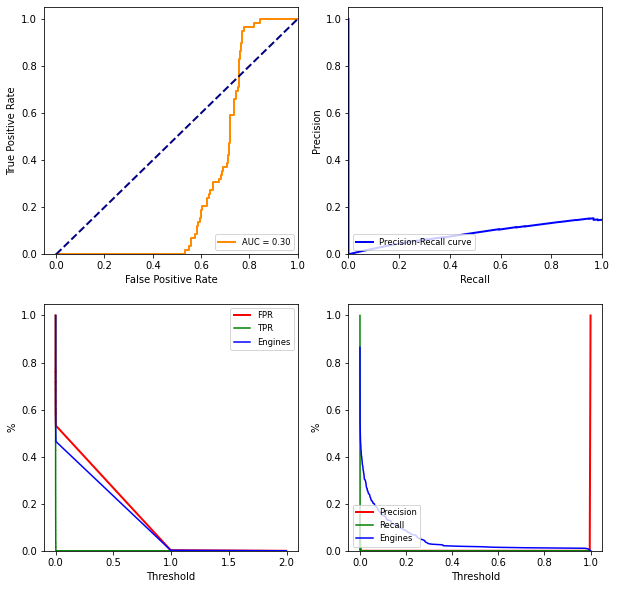

In [19]:
metrics_LogReg, roc_LogReg, prc_LogReg = bin_class_metrics(model, y_test, pred_LogReg.y_pred, pred_LogReg.y_score, print_out=True, plot_out=True)

In [20]:
y_test.value_counts()

0.0    406
1.0     59
Name: 60_days, dtype: int64

In [21]:
pred_LogReg.y_pred.value_counts()

0.0    457
1.0      8
Name: y_pred, dtype: int64

In [22]:
model = 'Random Forest B'
clf_rfcb = RandomForestClassifier(n_estimators=50, random_state=42)
gs_params = {'max_depth': [4, 5, 6, 7, 8], 'criterion': ['gini', 'entropy']}
gs_score = 'roc_auc'

In [23]:
clf_rfcb, pred_rfcb = bin_classify(model, clf_rfcb, X_train, X_test, y_train, y_test, params=gs_params, score=gs_score)
print('\nBest Parameters:\n',clf_rfcb)


Best Parameters:
 RandomForestClassifier(criterion='entropy', max_depth=5, n_estimators=50,
                       random_state=42)


/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


-----------------------------------------------------------
Random Forest B 

Confusion Matrix:
[[406   0]
 [ 59   0]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      1.00      0.93       406
         1.0       0.00      0.00      0.00        59

    accuracy                           0.87       465
   macro avg       0.44      0.50      0.47       465
weighted avg       0.76      0.87      0.81       465


Metrics:
           Random Forest B
Accuracy          0.873118
Precision         0.000000
Recall            0.000000
F1 Score          0.000000
ROC AUC           0.476037

ROC Thresholds:

     Threshold  TP  FP  TN  FN       TPR       FPR       TNR       FNR  \
0     1.415938   0  25  75   0  0.000000  0.000000  1.000000  0.750000   
1     0.415938   0  25  74   0  0.000000  0.002463  1.000000  0.747475   
2     0.411463   0  25  74   0  0.000000  0.004926  1.000000  0.747475   
3     0.402576   0  24  74   0  0.016949  0.

/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guilherme/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

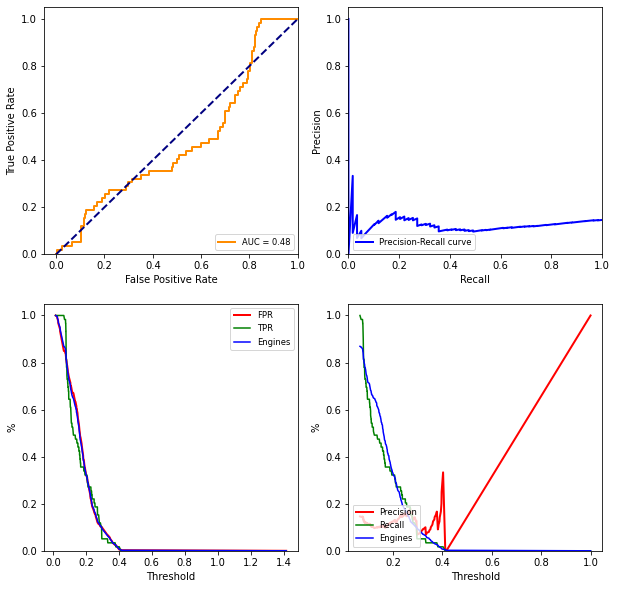

In [24]:
metrics_rfcb, roc_rfcb, prc_rfcb = bin_class_metrics(model, y_test, pred_rfcb.y_pred, pred_rfcb.y_score, print_out=True, plot_out=True)

<AxesSubplot:xlabel='y_score', ylabel='Count'>

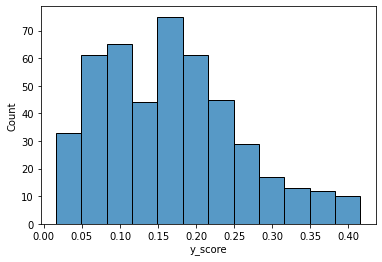

In [25]:
sns.histplot(pred_rfcb['y_score'])

In [32]:
pred_rfcb.iloc[190:210]

,y_pred,y_score
190,0.0,0.088607
191,0.0,0.060861
192,0.0,0.060513
193,0.0,0.281611
194,0.0,0.108575
195,0.0,0.079336
196,0.0,0.296698
197,0.0,0.324287
198,0.0,0.201681
199,0.0,0.319123


In [27]:
temp = y_test.to_frame()

In [28]:
temp[temp['60_days'] == 1]

,60_days
207,1.0
208,1.0
209,1.0
210,1.0
211,1.0
212,1.0
213,1.0
214,1.0
215,1.0
216,1.0
